In [1]:
# Importing the libraries
import numpy as np
import pandas as pd

# for visualization
import matplotlib.pyplot as plt

# calculate training time
import time

# for creation of validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

In [2]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# for reading ubyte file
!pip install idx2numpy
import idx2numpy

In [4]:
# import the data

trainimagefile = '/content/drive/My Drive/CNN for Image classification/Fashion MNIST/train_images'
trainlabelfile = '/content/drive/My Drive/CNN for Image classification/Fashion MNIST/train_labels'
testimagefile = '/content/drive/My Drive/CNN for Image classification/Fashion MNIST/test_images'
testlabelfile = '/content/drive/My Drive/CNN for Image classification/Fashion MNIST/test_labels'

X_train = idx2numpy.convert_from_file(trainimagefile)
y_train = idx2numpy.convert_from_file(trainlabelfile)
X_test = idx2numpy.convert_from_file(testimagefile)
y_test = idx2numpy.convert_from_file(testlabelfile)

In [5]:
labels = {"0":"T-shirt/top",
"1":"Trouser",
"2":"Pullover",
"3":"Dress",
"4":"Coat",
"5":"Sandal",
"6":"Shirt",
"7":"Sneaker",
"8":"Bag",
"9":"Ankle boot"}

T-shirt/top


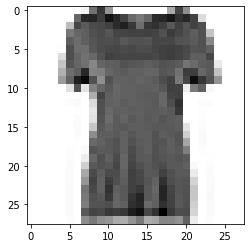

In [6]:
# display a image in trainset
id = 10
plt.imshow(X_train[id], cmap=plt.cm.binary)
print(labels[str(y_train[id])])

In [7]:
# create validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [8]:
# Shape of train (images) set
X_train.shape

(54000, 28, 28)

In [9]:
# Shape of validation (images) set
X_val.shape

(6000, 28, 28)

In [10]:
# reshape train set of images and create tensor from numpy array
X_train = X_train.reshape(54000, 1, 28, 28)
X_train = torch.from_numpy(X_train)

# create tensor for train set of labels
y_train = y_train.astype(int)
y_train = torch.from_numpy(y_train)

# sizes of tensors
X_train.shape, y_train.shape

(torch.Size([54000, 1, 28, 28]), torch.Size([54000]))

In [11]:
# reshape validation set of images and create tensor from numpy array
X_val = X_val.reshape(6000, 1, 28, 28)
X_val = torch.from_numpy(X_val)

# create tensor for validation set of labels
y_val = y_val.astype(int)
y_val = torch.from_numpy(y_val)

# sizes of tensors
X_val.shape, y_val.shape

(torch.Size([6000, 1, 28, 28]), torch.Size([6000]))

In [12]:
class Net(Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.cnn_layers = Sequential(
            # defining a 2d convolutions layer 
            Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # defining another 2d convolutional layer
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.linear_layers = Sequential(
            Linear(4*7*7, 10)
        )
    
    # defining the forward pass
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [13]:
# defining the model
model = Net()

# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.01)

# defining the loss function
criterion = CrossEntropyLoss()

# checking if CUDA device is availabel
if torch.cuda.is_available():
  model = model.cuda()
  criterion = criterion.cuda()

print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=196, out_features=10, bias=True)
  )
)


In [14]:
def train(epoch):
    model.train()
    tr_loss = 0
    
    # getting the training set
    X__train, y__train = Variable(X_train), Variable(y_train)
    
    # getting the validation set
    X__val, y__val = Variable(X_val), Variable(y_val)
    
    # coverting data to GPU format
    if torch.cuda.is_available():
      X__train = X__train.cuda()
      y__train = y__train.cuda()
      X__val = X__val.cuda()
      y__val = y__val.cuda()

    # clear the gradients of model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = model(X__train.float())
    output_val = model(X__val.float())
    
    # computing the training and validation loss
    loss_train = criterion(output_train, y__train)
    loss_val = criterion(output_val, y__val)
    train_losses.append(loss_train)
    val_losses.append(loss_val)
    
    # updation of weights
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch % 2 == 0:
        print('Epoch: ', epoch+1, '\t', 'loss: ', loss_val)

In [15]:
# number of epochs
n_epochs = 25

# empty lists to store the losses
train_losses = []
val_losses = []

# start time of training
start_time = time.time()

# training the model
for epoch in tqdm(range(n_epochs)):
    train(epoch)

# end time of training
end_time = time.time()

print("Time taken for training the model: ",end_time - start_time)

  4%|▍         | 1/25 [00:00<00:10,  2.19it/s]

Epoch:  1 	 loss:  tensor(2.4662, device='cuda:0', grad_fn=<NllLossBackward>)


 12%|█▏        | 3/25 [00:01<00:08,  2.49it/s]

Epoch:  3 	 loss:  tensor(1.6520, device='cuda:0', grad_fn=<NllLossBackward>)


 20%|██        | 5/25 [00:01<00:07,  2.66it/s]

Epoch:  5 	 loss:  tensor(1.1930, device='cuda:0', grad_fn=<NllLossBackward>)


 28%|██▊       | 7/25 [00:02<00:06,  2.74it/s]

Epoch:  7 	 loss:  tensor(0.9471, device='cuda:0', grad_fn=<NllLossBackward>)


 36%|███▌      | 9/25 [00:03<00:05,  2.79it/s]

Epoch:  9 	 loss:  tensor(0.8214, device='cuda:0', grad_fn=<NllLossBackward>)


 44%|████▍     | 11/25 [00:03<00:04,  2.81it/s]

Epoch:  11 	 loss:  tensor(0.7263, device='cuda:0', grad_fn=<NllLossBackward>)


 52%|█████▏    | 13/25 [00:04<00:04,  2.83it/s]

Epoch:  13 	 loss:  tensor(0.6703, device='cuda:0', grad_fn=<NllLossBackward>)


 60%|██████    | 15/25 [00:05<00:03,  2.82it/s]

Epoch:  15 	 loss:  tensor(0.6392, device='cuda:0', grad_fn=<NllLossBackward>)


 68%|██████▊   | 17/25 [00:06<00:02,  2.82it/s]

Epoch:  17 	 loss:  tensor(0.6107, device='cuda:0', grad_fn=<NllLossBackward>)


 76%|███████▌  | 19/25 [00:06<00:02,  2.82it/s]

Epoch:  19 	 loss:  tensor(0.5927, device='cuda:0', grad_fn=<NllLossBackward>)


 84%|████████▍ | 21/25 [00:07<00:01,  2.81it/s]

Epoch:  21 	 loss:  tensor(0.5698, device='cuda:0', grad_fn=<NllLossBackward>)


 92%|█████████▏| 23/25 [00:08<00:00,  2.81it/s]

Epoch:  23 	 loss:  tensor(0.5554, device='cuda:0', grad_fn=<NllLossBackward>)


100%|██████████| 25/25 [00:08<00:00,  2.79it/s]

Epoch:  25 	 loss:  tensor(0.5367, device='cuda:0', grad_fn=<NllLossBackward>)
Time taken for training the model:  8.950657367706299


<function matplotlib.pyplot.show>

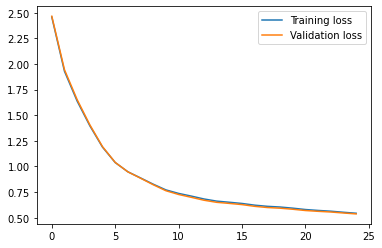

In [16]:
plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")
plt.legend()
plt.show

In [17]:
with torch.no_grad():
  output = model(X_train.float().cuda())

softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

print("Accuracy on the training set: ", accuracy_score(y_train, predictions))

Accuracy on the training set:  0.8096666666666666


In [18]:
with torch.no_grad():
  output = model(X_val.float().cuda())

softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

print("Accuracy on the validation set: ", accuracy_score(y_val, predictions))

Accuracy on the validation set:  0.81


In [19]:
X_test = X_test.reshape(10000, 1, 28, 28)
X_test = torch.from_numpy(X_test)

y_test = y_test.astype(int)
y_test = torch.from_numpy(y_test)

X_test.shape, y_test.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  


(torch.Size([10000, 1, 28, 28]), torch.Size([10000]))

In [20]:
with torch.no_grad():
  output = model(X_test.float().cuda())

softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

print("Accuracy on the test set: ", accuracy_score(y_test, predictions))

Accuracy on the test set:  0.7998


In [21]:
sample_submission = pd.read_csv('/content/drive/My Drive/CNN for Image classification/Fashion MNIST/sample_submission_I5njJSF.csv')

In [22]:
sample_submission['label'] = predictions
sample_submission.head()

,id,label
0,60001,9
1,60002,2
2,60003,1
3,60004,1
4,60005,6


In [23]:
sample_submission.to_csv('submission.csv', index=False)